# <img style="float: left; padding: 0px 10px 0px 0px;" src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/84/Escudo_de_la_Pontificia_Universidad_Cat%C3%B3lica_de_Chile.svg/1920px-Escudo_de_la_Pontificia_Universidad_Cat%C3%B3lica_de_Chile.svg.png"  width="80" /> MCD3100 - Ciencia de Datos Geoespaciales
**Pontificia Universidad Católica de Chile**<br>
**Magister en Ciencia de Datos**<br>

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import geemap,ee
import matplotlib.colors as colors
from shapely.geometry import shape, box
from matplotlib import colors
import matplotlib.patches as mpatches
import contextily as ctx

## 1. Introducción.

En este tutorial, continuaremos trabajando sobre el caso de estudio del incendio de diciembre de 2022 en la ciudad de Viña del Mar. En el ejercicio anterior (Tutorial N°6) aprendimos a usar la plataforma GEE para seleccionar imágenes de Sentinel 2 previas y posteriores al incendio, y a calcular índices normalizados de diferencia (NDVI y NBR)  generar y visualizar las zonas de vegetación más densar, y el área quemada en el incendio.

Ahora,veremos como procesar los productos de este análisis para cuantificar el área quemada, y calcular parámetros como la distancia a la que llegó el fuego de cada vivienda.

### Funciones de interés.

En este tutorial, realizaremos las siguientes operaciones:

- Leer el raster `dnbr.tif` exportado en el Tutorial 6.
- Clasificar los valores de `dNBR` para  identificar las zonas quemadas con distintos niveles de severidad.
- Crear máscaras para extraer las áreas severamente quemadas.
- Calcular la superficie quemada.
- Vectorizar el raster `dNBR`.
- Calcular la distancia entre cada vivienda, y la zona quemada.


## 2. Ejercicios.

### 2.1 Lectura del raster exportado anteriormente con rioxarray.

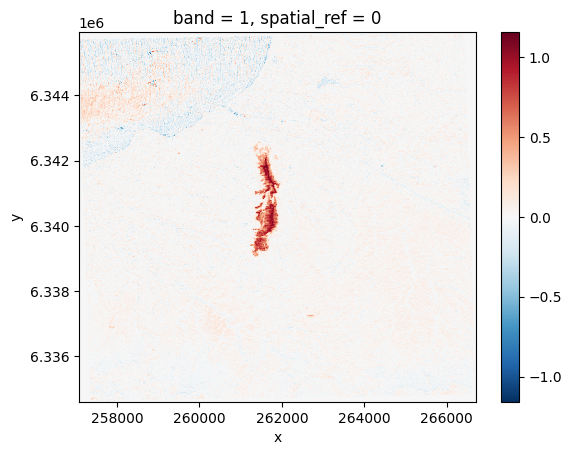

In [2]:
import rioxarray as rxr

#En el Tutorial 6 exportamos esta imagen:
#geemap.ee_export_image(dnbr, filename='dnbr.tif',crs='EPSG:32719', scale=10,region=aoi)

dnbr=rxr.open_rasterio('dnbr.tif')
dnbr.plot();

### 2.2 Clasificación  del raster dNBR.

El índice dNBR  (diferencia entre el NBR previo al incendio y el NBR posterior al incendio), obtenido a partir de las imágenes de Sentinel 2, permite estimar la severidad de la quema. Un valor más alto de dNBR indica un daño más severo, mientras que áreas con valores negativos de dNBR pueden indicar regeneración de la vegetación posterior al incendio. 

Los valores de dNBR pueden variar de un caso a otro, por lo que, cuando sea posible, su interpretación en situaciones específicas debería complementarse con evaluaciones en terreno, con el fin de obtener resultados más precisos. No obstante, el Servicio Geológico de los Estados Unidos (USGS) propuso una tabla de clasificación para interpretar la severidad de la quema, la cual se presenta en este link: https://un-spider.org/advisory-support/recommended-practices/recommended-practice-burn-severity/in-detail/normalized-burn-ratio


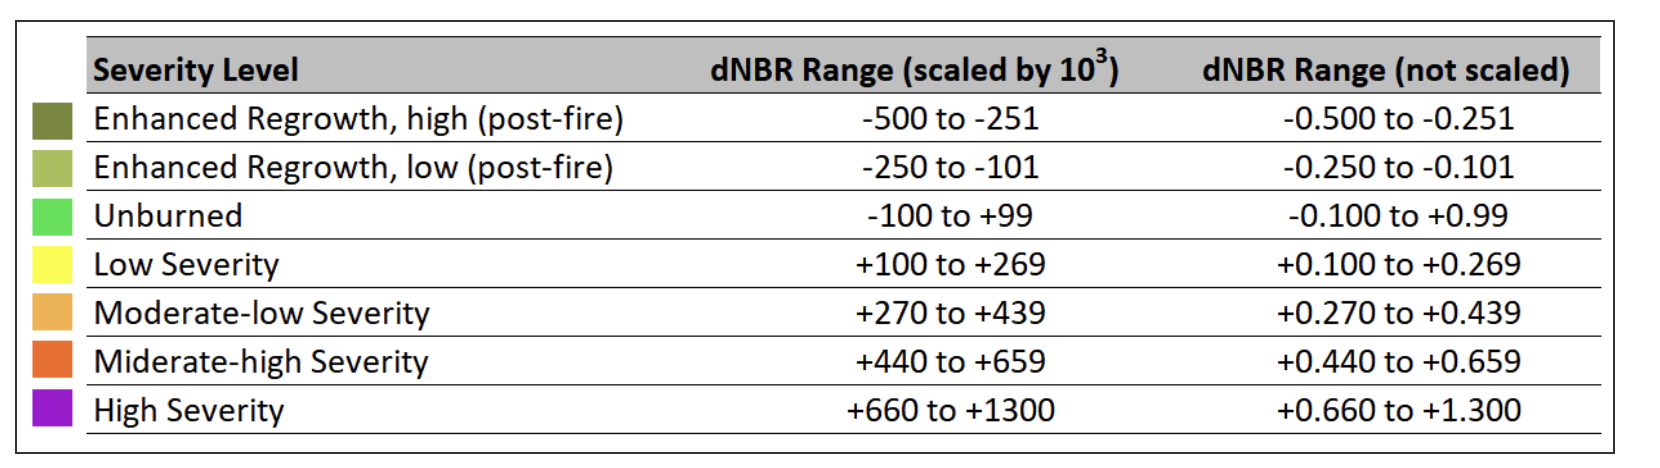

Para clasificar el raster dNBR de acuerdo a las categorías sugeridas por el USGS, usamos la función `reclassify` de `xarray`: https://xarray-spatial.readthedocs.io/en/stable/reference/_autosummary/xrspatial.classify.reclassify.html


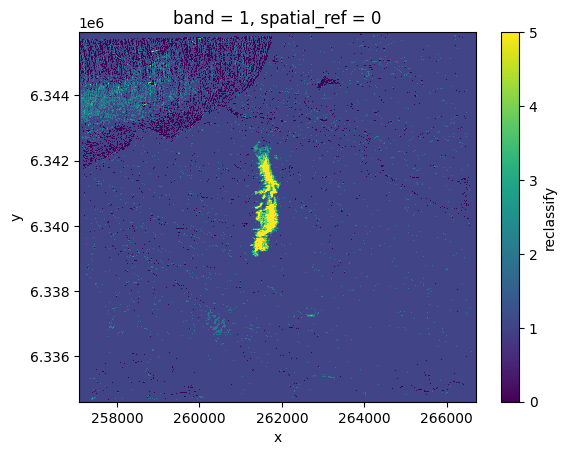

In [3]:
from xrspatial.classify import reclassify

#severity levels
sl={5:'very high',4:'high',3:'moderate-high',2:'moderate-low',1:'low',0:'unburned'}

bins=[-0.1,0.1,0.27,0.44,0.66, np.inf]
new_values=[0,1,2,3,4,5]

#Reclasificamos
nbr_class = reclassify(dnbr[0,::], bins=bins, new_values=new_values)

nbr_class.plot();

### 2.3 Enmascaramiento de pixeles correspondientes al mar.

En esta imagen reclasificada, es claro apreciar el ruido que se genera en la zona correspondiente al mar, donde hay pixeles que caen en la categoría "severamente quemado", lo cual es un error evidente. Para limpiar esta zona, podemos utilizar la *Capa de Clasificación de Escenas (SCL)* que se genera en el procesamiento de Sentinel-2 Nivel 2A (L2A), y vien eincluida en las imágenes multiespectrales. La banda se genera con una resolución espacial de 20 m junto con los productos L2-A. 

Puede encontrar la especificación de esta capa en el siguiente link: https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/scene-classification/

Ene stes caso particular, nos interesa crear una máscara para los pixeles con valor 6, es decir, clasificados como agua.


In [6]:
#Debe descomentar y ejecutar este código para descargar nuevamente la imagen previa al incendio. 
ee.Initialize(project='ee-erickbarrios3')
minx,miny,maxx,maxy=-71.6,-33.1,-71.5,-33,
xy=[[minx,miny],[maxx,miny],[maxx,maxy],[minx,maxy]]
print(xy)
aoi = ee.Geometry.Polygon(xy)
aoi
image=ee.Image('COPERNICUS/S2_SR_HARMONIZED/20221209T143731_20221209T144140_T19HBD').select(['B11', 'B8', 'B4','B3','B2','B1','SCL'])
geemap.ee_export_image(image, filename='20221219T143731_20221219T144224_T19HBD.tif',crs='EPSG:32719', scale=10,region=aoi)


[[-71.6, -33.1], [-71.5, -33.1], [-71.5, -33], [-71.6, -33]]
Generating URL ...
Please wait ...
Data downloaded to E:\proyectos\mcd_puc_codes\geods\tutoriales\tutorial7\20221219T143731_20221219T144224_T19HBD.tif


Leemos la imagen multiespectral previamente exportada:

In [7]:
im=rxr.open_rasterio('20221219T143731_20221219T144224_T19HBD.tif')

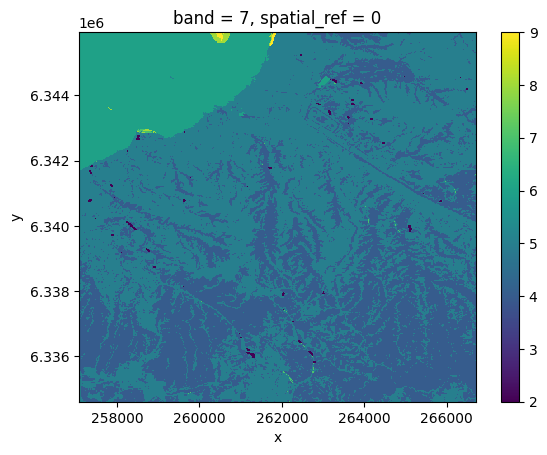

In [8]:
#Banda SCL (es la última de la lista de bandas)
scl=im[-1,::]
scl.plot();

Creamos una máscara binaria (True/False) para los pixeles con valor SCL=6:

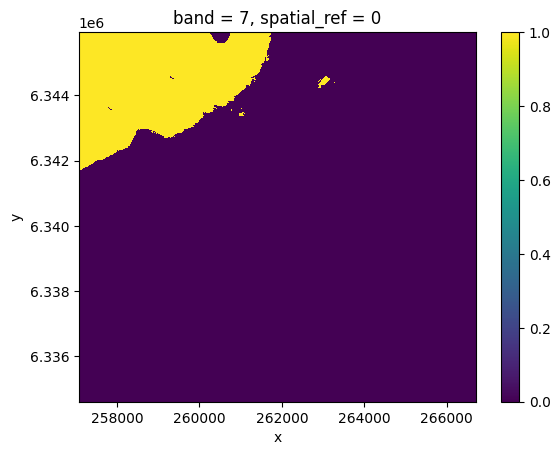

In [9]:
is_water = (im[-1,::] == 6)
is_water.plot();

Ahora aplicamos la máscara al raster dNBR previamente clasificado, para limpiar las zonas correspondientes al mar:

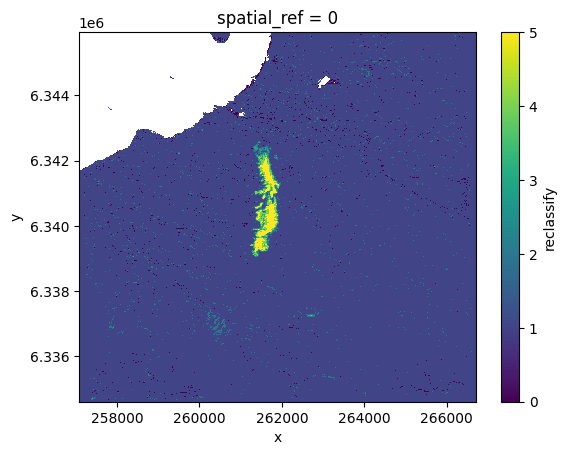

In [10]:
nbr_cm=nbr_class.where(~is_water)
nbr_cm.plot();

### 2.4 Cálculo de la superficie quemada.

Ahora de este raster filtrado, podemos seleccionar los pixeles con clases correspondientes a un nivel de queda moderado, alto o severo (**dNBR>2**). Para ello podemos recurrir al método `DataSet.where()`de `xarray`: https://xarray.pydata.org/en/v0.8.1/generated/xarray.Dataset.where.html

Esto es lo que identificaremos como las zonas quemadas: 

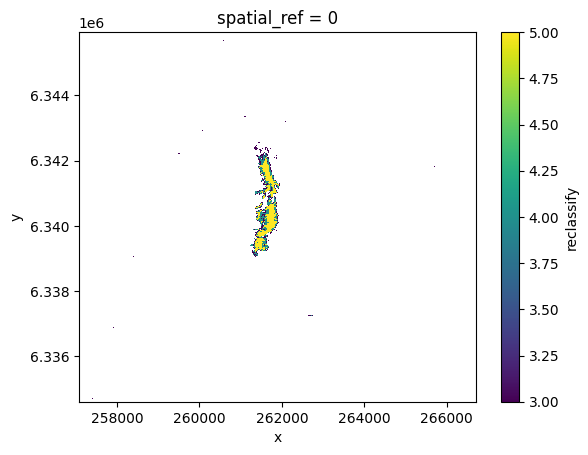

In [11]:
burnt=nbr_cm.where(nbr_cm>2)
burnt.plot();

Como nuestro raster está en coordenadas poryectadas (CRS 32719) y sabemos que cada pixel de Sentinel 2 tiene un tamaño de 10 x 10 mts, para calcular la superficie quemada total basta con contar la cantidad de pixeles en la figura anterior, y multiplicar por 100 para obtener la superficie en metros cuadrados. Luego dividimos por 10.000 para pasar a hectáreas:

In [12]:
burnt_area=burnt.count()*100/10000 #hectareas
print('Area quemada (Ha):',burnt_area.values)

Area quemada (Ha): 105.76


#### Nota: Busque en internet la superficie quemada reportada en distintas notas de prensa y reportes oficiales. ¿Coincide con su cálculo?

### 2.5 Vectorización del raster dNBR.  

Para hacer análisis combinados del raster dNBR con otros datos vectoriales, como por ejemplo el catastro de edificaciones dañadas que utilizamos en ejercicios anteriores, puede ser conveniente vectorizar: es decir, transformar la capa raster en una capa vectorial. Según el tipo de análisis a realizar, a veces también se requiere la operación inversa: rasterizar, o convertir una capa vectorial en un raster.

La librería `geocube` permite realizar ambas transformaciones: de GeoDataFrame a xarray, y de xarray a GeoDataFrame. Estas operaciones pueden ser muy útiles por ejemplo para el cálculo de estadísticas zonales, o mediciones de distancias entre geometrías y elementos de un raste.

https://corteva.github.io/geocube/stable/examples/examples.html

En estes caso, nuestro objetivo es: calcular la distancia de cada vivienda del catastro, al área quemada en el incendio. Para ello, vectorizamos el raster `dBNR` previamente clasificado,  y usamos la función `sjoin_nearest`de `geopandas` para realizar el cálculo de distancias entre cada vivienda, y el punto más cercano de la zona quemada.

In [13]:
#Vectorizamos el raster con la zona quemada
from geocube.vector import vectorize
gdf = vectorize(burnt)

Graficamos el raster vectorizado, ahora como un GeoDataFrame:

<Axes: >

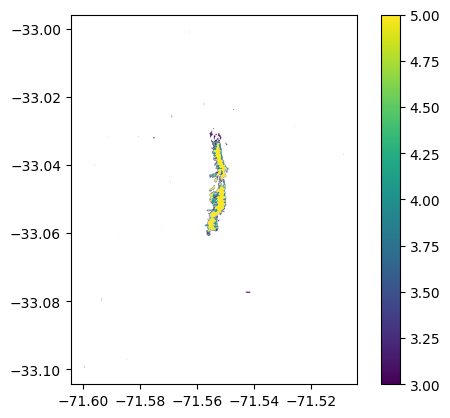

In [14]:
gdf.to_crs(4326).plot(column='reclassify',legend=True)

Ahora leemos y graficamos junto con la capa de Edificaciones. Dado que haremos cálculos de distancias, usanos el CRS 32719.

In [16]:
edif=gpd.read_file('Edificaciones.shp').to_crs(32719)

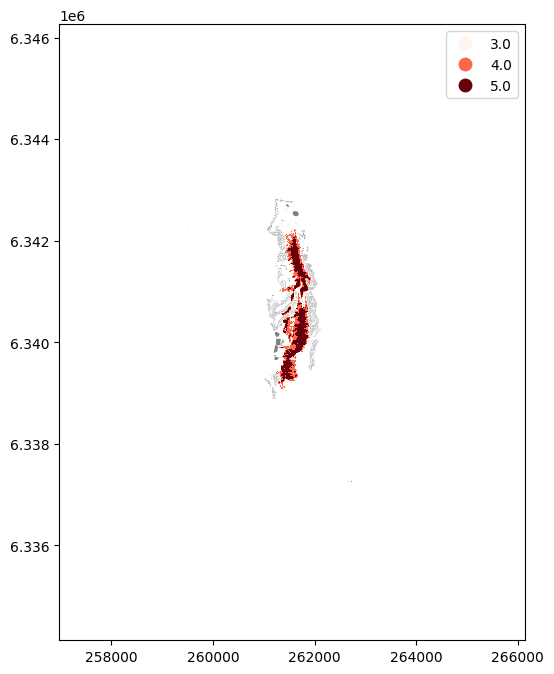

In [17]:
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(111)
gdf.plot(ax=ax,column='reclassify',legend=True,categorical=True,cmap='Reds',marker='s',markersize=5)

edif.plot(ax=ax,color='gray');


Para acotar el área, creamos un bounding box alrededor del conjunto de edificaciones, e intersectamos con el GeoDataFrame de áreas quemadas:

In [18]:
bbox=gpd.GeoDataFrame(geometry=[edif.unary_union.envelope],crs=32719)

#Seleccionamos las zonas quemadas dentro del bounding box de las edificaciones, para limpiar los datos.
gdf=gdf.overlay(bbox)

C:\Users\Erick\AppData\Local\Temp\ipykernel_20824\4051563065.py:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  bbox=gpd.GeoDataFrame(geometry=[edif.unary_union.envelope],crs=32719)


<Axes: >

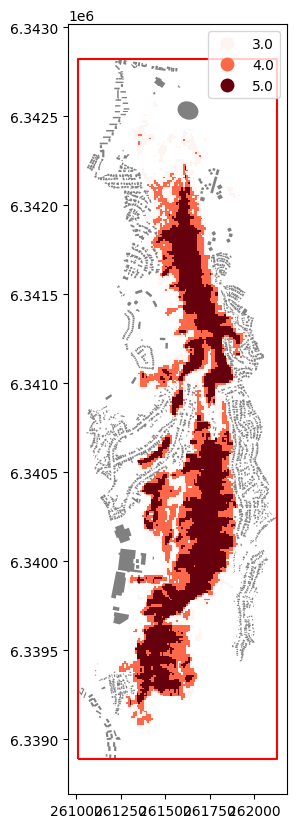

In [19]:
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111)
gdf.plot(ax=ax,column='reclassify',legend=True,categorical=True,cmap='Reds',marker='s',markersize=5)

edif.plot(ax=ax,color='gray')
bbox.boundary.plot(ax=ax,color='r')

### 2.5 Cálculo la distancia de cada vivienda al punto más cercano de la zona quemada.

Ahora podemos calcular nuestra variable objetivo: la distancia de cada vivienda, al punto más cercano de la zona quemada.

Dado que la capa de áreas quemadas contiene muchas geometrías superpuestas, es más conveniente pasar a una geometría de puntos para el cálculo de distancias a las viviendas:

In [20]:
# calculamos los centroides del area quemada porque las geometrias se traslapan y pueden dar calculos duplicados
gdf['geometry']=gdf.centroid

#distance_col indica en nombre de la columna donde se agrega la distancia al elemento más cercano 
edif_b=gpd.sjoin_nearest(edif,gdf,distance_col='Dist_burnt')

In [21]:
edif_b.head()

,Id,N_Pisos,Orientacio,Dist_Veget,Tamaño,Dist_estru,Prep_vivie,Mant_viv,N_Daño,Elevación,...,Cord_Y,Codigo_Pol,Dist_Sup,Material,Ac_Supresi,Dist_Foco,geometry,index_right,reclassify,Dist_burnt
0,0,8.0,NW,0.000000,416.620905,14.618534,Si,Si,Ninguno,98.769408,...,6.342136e+06,4006.0,130.769547,Sólido,Directo,94.833282,"POLYGON ((261696.949 6342153.144, 261697.232 6...",39,3.0,37.848235
1,0,8.0,NW,0.000000,177.487810,4.581179,Si,Si,Ninguno,112.203981,...,6.342111e+06,4007.0,150.980316,Sólido,Equipo,115.498544,"POLYGON ((261719.386 6342113.012, 261719.886 6...",56,3.0,59.709350
2,0,8.0,NW,1.413844,178.448386,4.581179,Si,Si,Ninguno,116.525468,...,6.342095e+06,4008.0,158.209747,Sólido,Equipo,123.252330,"POLYGON ((261730.392 6342098.534, 261730.879 6...",55,NaN,64.626229
3,0,8.0,NW,0.000000,179.175986,7.035498,Si,Si,Ninguno,116.349641,...,6.342116e+06,4009.0,178.044281,Sólido,Equipo,138.898349,"POLYGON ((261743.24 6342111.604, 261743.388 63...",51,3.0,69.429714
4,0,8.0,NW,0.981303,187.498583,7.258083,Si,Si,Ninguno,110.370876,...,6.342072e+06,4010.0,132.135742,Sólido,Equipo,95.493945,"POLYGON ((261700.653 6342080.531, 261701.207 6...",55,NaN,35.619250


Ahora podemos visualizar la distancia de cada vivienda al punto más cercano de la zona quemada:

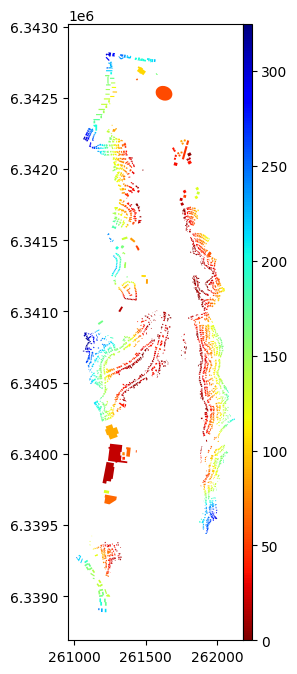

In [22]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(111)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0)

im=edif_b.plot(column='Dist_burnt',ax=ax,cmap='jet_r',legend=True,cax=cax)

cax.set_label('Distancia a la zona quemada (m)');